In [2]:
from typing import List, Optional, Tuple, Union

import copy
import json
import numpy
import random
import torch
import pandas
import seaborn as sns
import scipy.stats as sts
from scipy.stats import lognorm
from tqdm import tqdm as tqdm

# BED imports
from modelcomp.networks.fullyconnected import FullyConnected
from modelcomp.networks.summstats import NeuralSummStats, CAT_NSS
from modelcomp.simulators.bandits import simulate_bandit_batch, sim_bandit_prior
from modelcomp.utils.utils_human_participant_study import *

# matplotlib imports
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import to_rgb
from matplotlib.patches import Patch
from matplotlib import rc
%matplotlib inline
plt.style.use('default')
plt.rcParams['figure.figsize'] = (16.0, 8.0)
plt.rcParams.update({'font.size': 16})
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
device = torch.device('cpu')

# Load in Processed Data

## Posterior Data

In [16]:
# MD
md_savedata = torch.load('../data/md_posts_savedata.pt')

# PE WSLS
pe_wslts_savedata = torch.load('../data/pe_wslts_posts_savedata.pt')
corrs_pe_wslts_ensemble =  pe_wslts_savedata['corrs_opt_ensemble']
corrs_pe_wslts_ensemble_base = pe_wslts_savedata['corrs_base_ensemble']

# PE AEG
pe_aeg_savedata = torch.load('../data/pe_aeg_posts_savedata.pt')
corrs_pe_aeg_ensemble =  pe_aeg_savedata['corrs_opt_ensemble']
corrs_pe_aeg_ensemble_base = pe_aeg_savedata['corrs_base_ensemble']

# PE GLS
pe_gls_savedata = torch.load('../data/pe_gls_posts_savedata.pt')
corrs_pe_gls_ensemble =  pe_gls_savedata['corrs_opt_ensemble']
corrs_pe_gls_ensemble_base = pe_gls_savedata['corrs_base_ensemble']

## Entropy Data

In [17]:
# MD
md_entropies_data = torch.load('../data/md_entropies.pt')
md_entropies_opt = md_entropies_data['opt_ind']
md_entropies_base = md_entropies_data['base_ind']

# PE
pe_wslts_entropies_data = torch.load('../data/pe_wslts_entropies_ngrid30.pt')
pe_aeg_entropies_data = torch.load('../data/pe_aeg_entropies_ngrid100.pt')
pe_gls_entropies_data = torch.load('../data/pe_gls_entropies_ngrid10.pt')

# Quantitative Analysis

## Posterior Correlations

In [18]:
# Compute average inter-parameter correlations for optimal designs
average_corrs_wslts_opt = numpy.mean(corrs_pe_wslts_ensemble, axis=(0, 1))
average_corrs_aeg_opt = numpy.mean(corrs_pe_aeg_ensemble, axis=(0, 1))
average_corrs_gls_opt = numpy.mean(corrs_pe_gls_ensemble, axis=(0, 1))

# Compute average inter-parameter correlations for baseline designs
average_corrs_wslts_base = numpy.mean(corrs_pe_wslts_ensemble_base, axis=(0, 1))
average_corrs_aeg_base = numpy.mean(corrs_pe_aeg_ensemble_base, axis=(0, 1))
average_corrs_gls_base = numpy.mean(corrs_pe_gls_ensemble_base, axis=(0, 1))

100%|██████████| 6/6 [00:00<00:00, 69.70it/s]


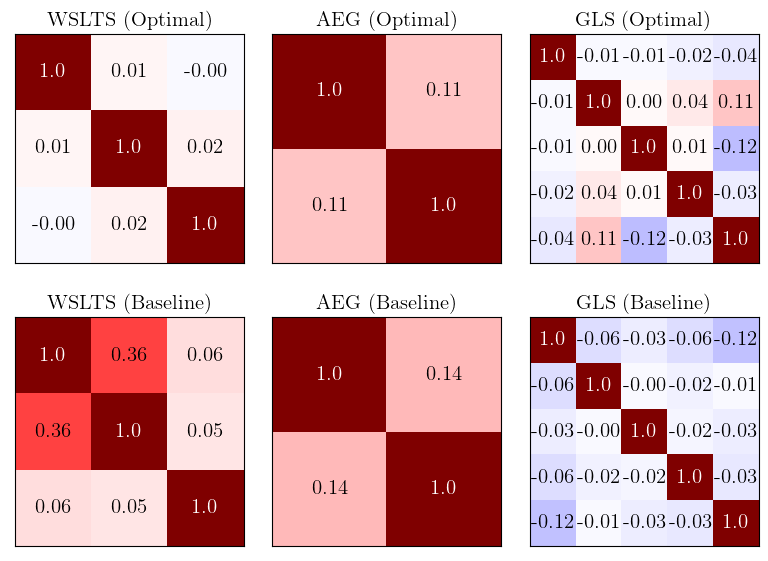

In [19]:
corrs = [average_corrs_wslts_opt, average_corrs_aeg_opt, average_corrs_gls_opt,
         average_corrs_wslts_base, average_corrs_aeg_base, average_corrs_gls_base]
sizes = [3, 2, 5, 3, 2, 5]
names = ['WSLTS (Optimal)', 'AEG (Optimal)', 'GLS (Optimal)',
         'WSLTS (Baseline)', 'AEG (Baseline)', 'GLS (Baseline)']

fig = plt.figure(figsize=(8, 6))

it = 0
for crs in tqdm(corrs):
    
    it += 1
    ax1 = fig.add_subplot(2, 3, it)
    fig, ax1, _ = plot_correlations(
        crs, fig, ax1, num_decimals=2,
        colorbar=False, numsize=15, cmap='seismic', size=sizes[it-1])
    ax1.set_xticks([])
    ax1.set_yticks([]);
    
    ax1.set_title(names[it-1], size=15)
    
plt.tight_layout();

## Posterior Entropies

In [20]:
# define green colors for plotting
green_full = (*to_rgb(cycle[2]), 1)
green_alpha = (*to_rgb(cycle[2]), 0.2)
# define orange colors for plotting
orange_full = (*to_rgb(cycle[1]), 1)
orange_alpha = (*to_rgb(cycle[1]), 0.2)

### MD: Shannon Entropy Plots

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


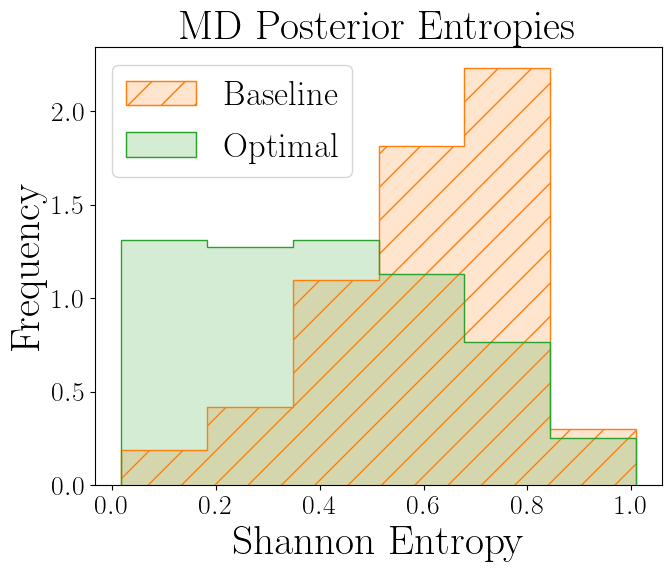

In [21]:
fig = plt.figure(figsize=(7, 6))

ax = fig.add_subplot(111)

opt = numpy.median(md_entropies_opt, axis=1)
base = numpy.median(md_entropies_base, axis=1)

j = numpy.hstack((opt, base))

hatch_opt = ''
hatch_base = '/'

BINS = 6
bins = numpy.linspace(numpy.min(j), numpy.max(j), BINS + 1)
ax.hist(base, bins=bins, alpha=0.2, density=True, color=cycle[1])
ax.hist(base, bins=bins, alpha=1, density=True, histtype='step', edgecolor=cycle[1], hatch=hatch_base)
ax.hist(opt, bins=bins, alpha=0.2, density=True, color=cycle[2])
ax.hist(opt, bins=bins, alpha=1, density=True, histtype='step', edgecolor=cycle[2], hatch=hatch_opt) #, hatch='x')
ax.set_xlabel('Shannon Entropy', size=30)
ax.set_ylabel('Frequency', size=30)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=15)
# ax.grid(True, ls='--')
handles = (
    (Patch(facecolor=orange_alpha, edgecolor=orange_alpha, hatch=hatch_base),
           Patch(edgecolor=orange_full, fill=None, hatch=hatch_base)),
    (Patch(facecolor=green_alpha, edgecolor=green_alpha, hatch=hatch_opt),
           Patch(edgecolor=green_full, fill=None, hatch=hatch_opt)),
)
ax.set_title('MD Posterior Entropies', size=30)
ax.legend(handles=handles, labels=('Baseline', 'Optimal',), loc='upper left', prop={'size': 25})
plt.tight_layout();

### PE: Differential Entropy Plots

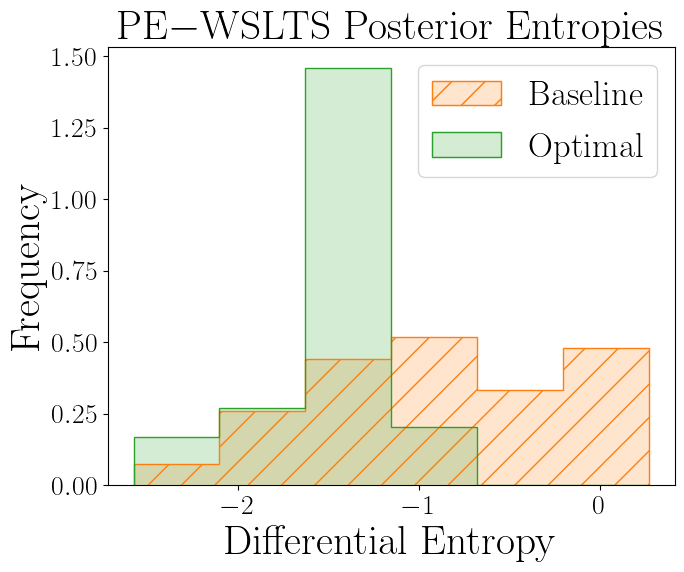

In [22]:
fig = plt.figure(figsize=(7, 6))

ax = fig.add_subplot(111)

opt = numpy.median(pe_wslts_entropies_data['opt_ind'], axis=1)
base = numpy.median(pe_wslts_entropies_data['base_ind'], axis=1)

j = numpy.hstack((opt, base))

hatch_opt = ''
hatch_base = '/'

BINS = 6
bins = numpy.linspace(numpy.min(j), numpy.max(j), BINS + 1)
ax.hist(base, bins=bins, alpha=0.2, density=True, color=cycle[1])
ax.hist(base, bins=bins, alpha=1, density=True, histtype='step', edgecolor=cycle[1], hatch=hatch_base)
ax.hist(opt, bins=bins, alpha=0.2, density=True, color=cycle[2])
ax.hist(opt, bins=bins, alpha=1, density=True, histtype='step', edgecolor=cycle[2], hatch=hatch_opt) #, hatch='x')

ax.set_xlabel('Differential Entropy', size=30)
ax.set_ylabel('Frequency', size=30)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=15)
# ax.grid(True, ls='--')
handles = (
    (Patch(facecolor=orange_alpha, edgecolor=orange_alpha, hatch=hatch_base),
           Patch(edgecolor=orange_full, fill=None, hatch=hatch_base)),
    (Patch(facecolor=green_alpha, edgecolor=green_alpha, hatch=hatch_opt),
           Patch(edgecolor=green_full, fill=None, hatch=hatch_opt)),
)
ax.set_title(r'PE$-$WSLTS Posterior Entropies', size=30)
ax.legend(handles=handles, labels=('Baseline', 'Optimal',), loc='upper right', prop={'size': 25})
plt.tight_layout();

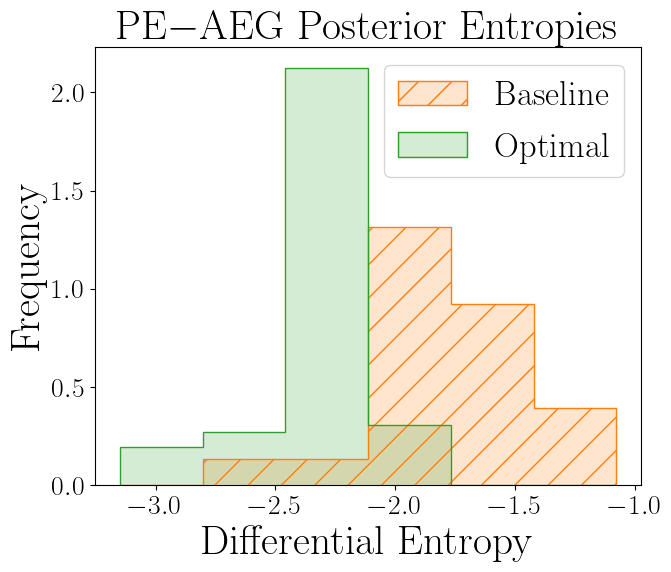

In [23]:
fig = plt.figure(figsize=(7, 6))

ax = fig.add_subplot(111)

opt = numpy.median(pe_aeg_entropies_data['opt_ind'], axis=1)
base = numpy.median(pe_aeg_entropies_data['base_ind'], axis=1)

j = numpy.hstack((opt, base))

hatch_opt = ''
hatch_base = '/'

BINS = 6
bins = numpy.linspace(numpy.min(j), numpy.max(j), BINS + 1)
ax.hist(base, bins=bins, alpha=0.2, density=True, color=cycle[1])
ax.hist(base, bins=bins, alpha=1, density=True, histtype='step', edgecolor=cycle[1], hatch=hatch_base)
ax.hist(opt, bins=bins, alpha=0.2, density=True, color=cycle[2])
ax.hist(opt, bins=bins, alpha=1, density=True, histtype='step', edgecolor=cycle[2], hatch=hatch_opt) #, hatch='x')

ax.set_xlabel('Differential Entropy', size=30)
ax.set_ylabel('Frequency', size=30)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=15)
# ax.grid(True, ls='--')
handles = (
    (Patch(facecolor=orange_alpha, edgecolor=orange_alpha, hatch=hatch_base),
           Patch(edgecolor=orange_full, fill=None, hatch=hatch_base)),
    (Patch(facecolor=green_alpha, edgecolor=green_alpha, hatch=hatch_opt),
           Patch(edgecolor=green_full, fill=None, hatch=hatch_opt)),
)
ax.set_title(r'PE$-$AEG Posterior Entropies', size=30)
ax.legend(handles=handles, labels=('Baseline', 'Optimal',), loc='upper right', prop={'size': 25})
plt.tight_layout();

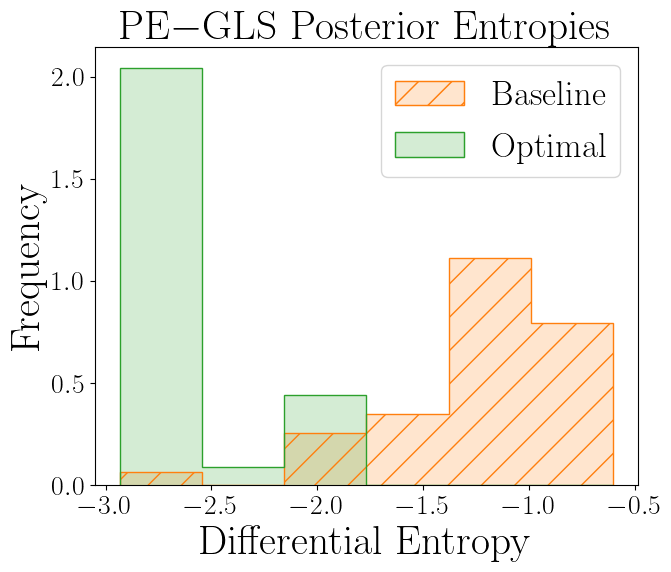

In [24]:
fig = plt.figure(figsize=(7, 6))

ax = fig.add_subplot(111)

opt = numpy.median(pe_gls_entropies_data['opt_ind'], axis=1)
base = numpy.median(pe_gls_entropies_data['base_ind'], axis=1)

j = numpy.hstack((opt, base))

hatch_opt = ''
hatch_base = '/'

BINS = 6
bins = numpy.linspace(numpy.min(j), numpy.max(j), BINS + 1)
ax.hist(base, bins=bins, alpha=0.2, density=True, color=cycle[1])
ax.hist(base, bins=bins, alpha=1, density=True, histtype='step', edgecolor=cycle[1], hatch=hatch_base)
ax.hist(opt, bins=bins, alpha=0.2, density=True, color=cycle[2])
ax.hist(opt, bins=bins, alpha=1, density=True, histtype='step', edgecolor=cycle[2], hatch=hatch_opt) #, hatch='x')

ax.set_xlabel('Differential Entropy', size=30)
ax.set_ylabel('Frequency', size=30)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=15)
# ax.grid(True, ls='--')
handles = (
    (Patch(facecolor=orange_alpha, edgecolor=orange_alpha, hatch=hatch_base),
           Patch(edgecolor=orange_full, fill=None, hatch=hatch_base)),
    (Patch(facecolor=green_alpha, edgecolor=green_alpha, hatch=hatch_opt),
           Patch(edgecolor=green_full, fill=None, hatch=hatch_opt)),
)
ax.set_title(r'PE$-$GLS Posterior Entropies', size=30)
ax.legend(handles=handles, labels=('Baseline', 'Optimal',), loc='upper right', prop={'size': 25})
plt.tight_layout();

# Qualitative Analysis

## Compute Mean/MAP estimates and KDEs of Posteriors

In [25]:
def get_pe_posterior_summary_with_kde(posterior_samples, grid_list):
    
    pe_posts_kdes = list()
    pe_posts_means = list()
    pe_posts_medians = list()
    pe_posts_maps = list()
    for participant in tqdm(range(len(posterior_samples))):

        kdes_tmp = list()
        means_tmp = list()
        medians_tmp = list()
        maps_tmp = list()
        for model_num in range(len(posterior_samples[participant])):

            post_samples = posterior_samples[participant, model_num, :, :]

            # compute kde
            kde_theta = [
                sts.gaussian_kde(post_samples[:, i], bw_method='silverman') \
                for i in range(post_samples.shape[-1])
            ]
            kdes_tmp.append([kde_theta[i].pdf(grid_list[i]) for i in range(len(kde_theta))])
            maps_tmp.append([grid_list[i][numpy.argmax(kde_theta[i])] for i in range(len(kde_theta))])

            # compute means and median
            means = numpy.mean(post_samples, axis=0)
            means_tmp.append(means)
            medians = numpy.median(post_samples, axis=0)
            medians_tmp.append(medians)

        pe_posts_kdes.append(kdes_tmp)
        pe_posts_means.append(means_tmp)
        pe_posts_medians.append(medians_tmp)
        pe_posts_maps.append(maps_tmp)

    pe_posts_kdes = numpy.array(pe_posts_kdes)
    pe_posts_means = numpy.array(pe_posts_means)
    pe_posts_medians = numpy.array(pe_posts_medians)
    pe_posts_maps = numpy.array(pe_posts_maps)
    
    return pe_posts_means, pe_posts_medians, pe_posts_maps, pe_posts_kdes

In [26]:
pe_aeg_posts_samples = torch.load('../data/pe_aeg_posts_samples_10k.pt')

In [27]:
grids_aeg_list = [
    numpy.linspace(0, 1, 20, endpoint=True),
    numpy.linspace(0, 1, 20, endpoint=True)
]

In [28]:
pe_aeg_summary = get_pe_posterior_summary_with_kde(pe_aeg_posts_samples, grids_aeg_list)
pe_aeg_posts_means = pe_aeg_summary[0]
pe_aeg_posts_medians = pe_aeg_summary[1]
pe_aeg_posts_maps = pe_aeg_summary[2]
pe_aeg_posts_kdes = pe_aeg_summary[3]

100%|██████████| 75/75 [00:21<00:00,  3.48it/s]


## PE Example Posterior Plots

### WSLTS

In [29]:
# TODO: Still need to do this, do you have the code, @Simon?

### AEG

In [30]:
# compute means of kdes over ensemble predictions
kdes_means = numpy.mean(pe_aeg_posts_kdes, axis=1)

In [31]:
ID_0 = 1
ID_1 = 6

In [32]:
maxes = numpy.max(kdes_means[[ID_0, ID_1]], axis=(0, 2))
max_th0 = maxes[0]
max_th1 = maxes[1]

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


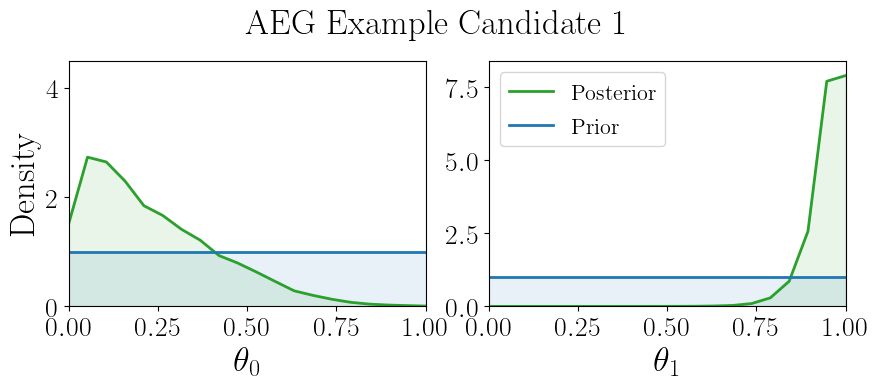

In [33]:
fig = plt.figure(figsize=(9, 4))

ax0 = fig.add_subplot(121)
ax0.plot(grids_aeg_list[0], kdes_means[ID_0][0], color=cycle[2], lw=2, alpha=1)
ax0.fill_between(grids_aeg_list[0], kdes_means[ID_0][0], color=cycle[2], lw=1, alpha=0.1)
ax0.plot(grids_aeg_list[0], numpy.ones(len(grids_aeg_list[0])), color=cycle[0], lw=2)
ax0.fill_between(grids_aeg_list[0], numpy.ones(len(grids_aeg_list[0])), color=cycle[0], lw=1, alpha=0.1)
ax0.set_xlabel(r'$\theta_0$', size=25)
ax0.set_ylabel(r'Density', size=25)
ax0.set_xlim([0, 1])
ax0.tick_params(axis='both', which='major', labelsize=20)
# ax0.set_ylim([0, np.max(kdes_means[ID_0][0])+0.5])
ax0.set_ylim([0, max_th0 + 0.25])

ax1 = fig.add_subplot(122)
ax1.plot(grids_aeg_list[1], kdes_means[ID_0][1], color=cycle[2], lw=2, label='Posterior')
ax1.fill_between(grids_aeg_list[1], kdes_means[ID_0][1], color=cycle[2], lw=1, alpha=0.1)
ax1.plot(grids_aeg_list[1], numpy.ones(len(grids_aeg_list[1])), color=cycle[0], lw=2, label='Prior')
ax1.fill_between(grids_aeg_list[1], numpy.ones(len(grids_aeg_list[1])), color=cycle[0], lw=1, alpha=0.1)
ax1.set_xlabel(r'$\theta_1$', size=25)
# ax1.set_ylabel(r'Posterior PDF', size=20)
ax1.set_xlim([0, 1])
ax1.tick_params(axis='both', which='major', labelsize=20)
ax1.tick_params(axis='both', which='minor', labelsize=15)
# ax1.set_ylim([0, np.max(kdes_means[ID_0][1])+0.5])
ax1.set_ylim([0, max_th1 + 0.50])
ax1.legend(loc='upper left')

plt.suptitle('AEG Example Candidate 1', size=25)

plt.tight_layout();
plt.subplots_adjust(top=0.85)

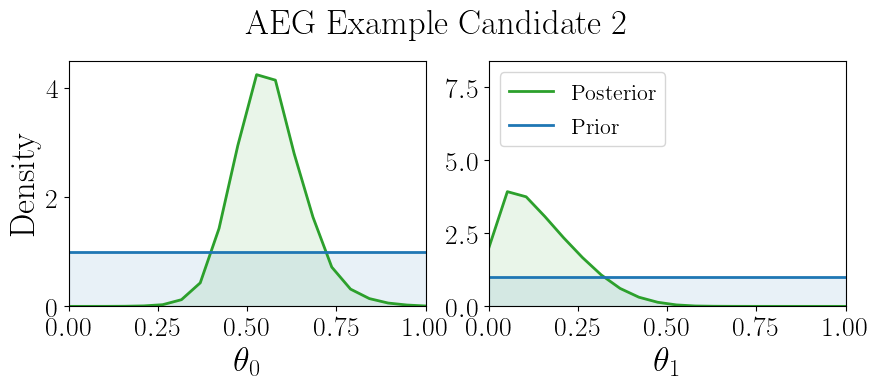

In [34]:
fig = plt.figure(figsize=(9, 4))

ax0 = fig.add_subplot(121)
ax0.plot(grids_aeg_list[0], kdes_means[ID_1][0], color=cycle[2], lw=2, alpha=1)
ax0.fill_between(grids_aeg_list[0], kdes_means[ID_1][0], color=cycle[2], lw=1, alpha=0.1)
ax0.plot(grids_aeg_list[0], numpy.ones(len(grids_aeg_list[0])), color=cycle[0], lw=2)
ax0.fill_between(grids_aeg_list[0], numpy.ones(len(grids_aeg_list[0])), color=cycle[0], lw=1, alpha=0.1)
ax0.set_xlabel(r'$\theta_0$', size=25)
ax0.set_ylabel(r'Density', size=25)
ax0.set_xlim([0, 1])
ax0.tick_params(axis='both', which='major', labelsize=20)
# ax0.set_ylim([0, np.max(kdes_means[ID_0][0])+0.5])
ax0.set_ylim([0, max_th0 + 0.25])

ax1 = fig.add_subplot(122)
ax1.plot(grids_aeg_list[1], kdes_means[ID_1][1], color=cycle[2], lw=2, label='Posterior')
ax1.fill_between(grids_aeg_list[1], kdes_means[ID_1][1], color=cycle[2], lw=1, alpha=0.1)
ax1.plot(grids_aeg_list[1], numpy.ones(len(grids_aeg_list[1])), color=cycle[0], lw=2, label='Prior')
ax1.fill_between(grids_aeg_list[1], numpy.ones(len(grids_aeg_list[1])), color=cycle[0], lw=1, alpha=0.1)
ax1.set_xlabel(r'$\theta_1$', size=25)
# ax1.set_ylabel(r'Posterior PDF', size=20)
ax1.set_xlim([0, 1])
ax1.tick_params(axis='both', which='major', labelsize=20)
ax1.tick_params(axis='both', which='minor', labelsize=15)
# ax1.set_ylim([0, np.max(kdes_means[ID_0][1])+0.5])
ax1.set_ylim([0, max_th1 + 0.50])
ax1.legend(loc='upper left')

plt.suptitle('AEG Example Candidate 2', size=25)

plt.tight_layout();
plt.subplots_adjust(top=0.85)

### GLS

In [35]:
# TODO: Still need to do this, do you have the code, @Simon?

### PE-AEG Summary Posterior Mean Plot

In [36]:
# median of posterior means, for robustness
means_medians = numpy.median(pe_aeg_posts_means, axis=1)

In [37]:
ID_0 = 1
ID_1 = 6

In [39]:
df = pandas.DataFrame({
    r'$\theta_0$': means_medians[:, 0],
    r'$\theta_1$': means_medians[:, 1]}).drop([ID_0, ID_1])

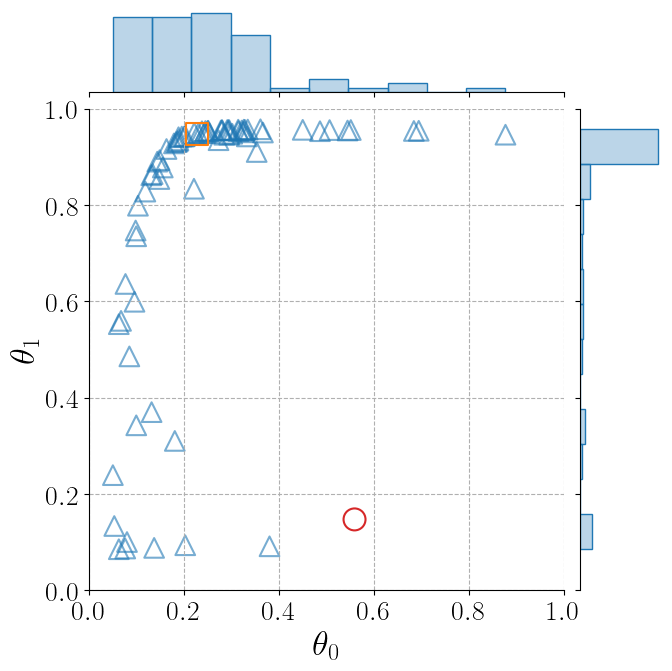

In [40]:
g = sns.JointGrid(x=r'$\theta_0$', y=r'$\theta_1$', height=7, data=df)

g.plot_joint(sns.scatterplot, s=200, marker='^', facecolor='none', edgecolor=cycle[0], linewidth=1.5, alpha=0.6)
g.plot_marginals(sns.histplot, kde=False, alpha=0.3, edgecolor=cycle[0])

ax = g.ax_joint
ax.grid(True, ls='--')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xlabel(r'$\theta_0$', size=25)
ax.set_ylabel(r'$\theta_1$', size=25)

ax.scatter(
    means_medians[ID_0, 0], means_medians[ID_0, 1], label='Ex. Candidate 1',
    s=250, marker=',', facecolor='none', edgecolor=cycle[1], linewidth=1.5
)
ax.scatter(
    means_medians[ID_1, 0], means_medians[ID_1, 1], label='Ex. Candidate 2',
    s=250, marker='o', facecolor='none', edgecolor=cycle[3], linewidth=1.5
)
# ax.legend(loc='center right')

ax_marg_x = g.ax_marg_x
ax_marg_x.set_xlim([0, 1])
ax_marg_y = g.ax_marg_y
ax_marg_y.set_ylim([0, 1])

plt.tight_layout();
plt.subplots_adjust(hspace=0.2, wspace=0.2)